
# Credit Risk EDA (Professional, Model-Oriented)

This notebook performs a full, professional-grade EDA for a credit risk dataset (e.g., German Credit or similar).  
It auto-detects a candidate target, computes class balance, runs data quality checks, univariate/bivariate/multivariate analyses, and exports tables & plots for modeling.


In [32]:

# === Parameters ===
# Path to your CSV file (update as needed)
CSV_PATH = "taiwan_default_of_credit_card_clients.csv"

# Output directory (all exports will be saved here)
OUTPUT_DIR = "taiwan_eda"

In [33]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Create output directories
root = Path(OUTPUT_DIR)
plots_dir = root / "plots"
tables_dir = root / "tables"
root.mkdir(exist_ok=True, parents=True)
plots_dir.mkdir(exist_ok=True, parents=True)
tables_dir.mkdir(exist_ok=True, parents=True)

pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 100)


In [34]:

# === Load dataset ===
df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head()


(30001, 25)


,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0


In [35]:

# === Detect candidate target ===
def detect_target(df):
    common_names = [
        "risk","target","label","default","is_default","loan_status","bad_loan",
        "seriousdlqin2yrs","delinquent","default_ind","y","outcome"
    ]
    cols_lower = {c.lower(): c for c in df.columns}
    for nm in common_names:
        if nm in cols_lower:
            return cols_lower[nm], "Matched common target name."
    nunique = df.nunique(dropna=True)
    # Binary columns first
    binary_cols = [c for c in df.columns if nunique[c] == 2]
    if binary_cols:
        best_c, best_imb = None, -1.0
        for c in binary_cols:
            vc = df[c].value_counts(normalize=True, dropna=True)
            if len(vc) == 2:
                imb = float(abs(vc.iloc[0] - (1 - vc.iloc[0])))
            else:
                imb = 0.0
            if imb > best_imb:
                best_imb, best_c = imb, c
        if best_c:
            return best_c, "Inferred from binary column with strongest imbalance."
    # Fallback: small-cardinality
    small = [c for c in df.columns if nunique[c] <= 5]
    if small:
        return small[0], "Heuristic small-cardinality column."
    return None, "No clear target."

target_col, target_reason = detect_target(df)
print("Candidate target:", target_col, "| Reason:", target_reason)


Candidate target: Y | Reason: Matched common target name.


In [36]:
# === Clean columns & normalize target (robust, no NaN-int cast) ===
index_like = [c for c in df.columns if c.lower().startswith("unnamed") or c.lower() in {"id","index"}]
dfc = df.drop(columns=index_like) if index_like else df.copy()

dfc = dfc.copy()
dfc["__target_bin__"] = pd.NA  # create placeholder (nullable)

if target_col and target_col in dfc.columns:
    # Normalize strings
    s_raw = dfc[target_col]
    s = s_raw.astype(str).str.strip().str.lower()

    # Map common label forms to 0/1
    label_map = {
        "good": 0, "bad": 1,
        "yes": 1, "no": 0,
        "y": 1, "n": 0,
        "true": 1, "false": 0,
        "t": 1, "f": 0,
        "1": 1, "0": 0
    }
    mapped = s.map(label_map)

    # Try numeric fallback
    nums = pd.to_numeric(s, errors="coerce")

    # Choose best available binary signal
    # Priority 1: explicit mapped labels
    if mapped.notna().any():
        tmp = mapped
    # Priority 2: numeric values that are 0/1 (ignore other numbers)
    elif nums.notna().any() and nums.dropna().isin([0, 1]).all():
        tmp = nums
    else:
        tmp = pd.Series(pd.NA, index=dfc.index)  # no valid binary mapping

    # Keep only rows with valid 0/1 after mapping
    valid_mask = tmp.isin([0, 1])
    dropped = (~valid_mask).sum()

    # If nothing valid, don't create __target_bin__ and continue gracefully
    if valid_mask.any():
        dfc = dfc.loc[valid_mask].copy()
        dfc["__target_bin__"] = tmp.loc[valid_mask].astype(int)  # safe: no NaNs remain
        print(f"Target '{target_col}' normalized to __target_bin__. Dropped {dropped} rows with invalid/missing target.")
    else:
        # leave __target_bin__ as NA and report
        print(f"Could not normalize '{target_col}' to a binary target (found no valid 0/1 or known labels).")

shape_info = {
    "n_rows": len(dfc),
    "n_cols": dfc.shape[1],
    "candidate_target": target_col,
    "target_reason": target_reason,
    "index_like_cols": index_like,
}
shape_info


Target 'Y' normalized to __target_bin__. Dropped 1 rows with invalid/missing target.


{'n_rows': 30000,
 'n_cols': 25,
 'candidate_target': 'Y',
 'target_reason': 'Matched common target name.',
 'index_like_cols': ['Unnamed: 0']}

In [37]:

# === Data Understanding ===
dtypes = dfc.dtypes.astype(str).rename("dtype").to_frame()
unique_counts = dfc.nunique(dropna=True).rename("n_unique")
dtypes_full = dtypes.join(unique_counts)
dtypes_full.to_csv(Path(tables_dir) / "dtypes_unique.csv")
dtypes_full.head(50)


,dtype,n_unique
X1,object,81
X2,object,2
X3,object,7
X4,object,4
X5,object,56
X6,object,11
X7,object,11
X8,object,11
X9,object,11
X10,object,10


In [38]:

# === Class balance (if target present) ===
if target_col and target_col in dfc.columns:
    cb = dfc[target_col].value_counts(dropna=False).rename("count").to_frame()
    cb["pct"] = (cb["count"]/cb["count"].sum()*100).round(2)
    cb.to_csv(Path(tables_dir) / "class_balance.csv")
    display(cb)


,count,pct
Y,,
0,23364,77.88
1,6636,22.12


,missing,missing_pct
X1,0,0.0
X2,0,0.0
X3,0,0.0
X4,0,0.0
X5,0,0.0
X6,0,0.0
X7,0,0.0
X8,0,0.0
X9,0,0.0
X10,0,0.0


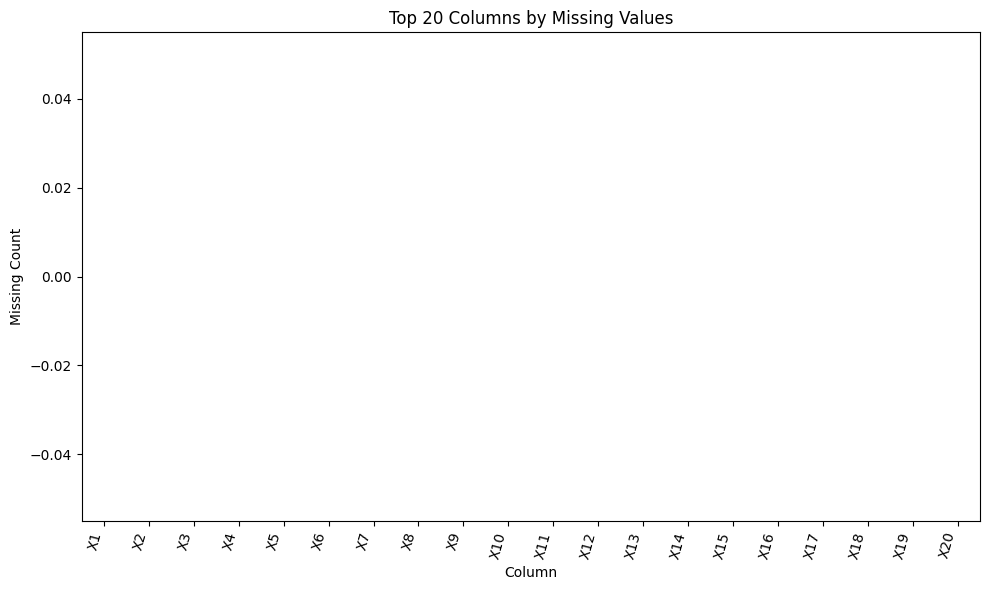

Duplicate rows: 35


In [39]:
# === Missingness & duplicates ===
missing_tbl = (
    dfc.isna().sum().to_frame("missing")
    .assign(missing_pct=lambda x: (x["missing"]/len(dfc)*100).round(2))
    .sort_values("missing", ascending=False)
)
missing_tbl.to_csv(Path(tables_dir) / "missingness.csv")
display(missing_tbl.head(50))

# Plot missingness (Top 20)
top_missing = missing_tbl.head(20)
plt.figure(figsize=(10,6))
top_missing["missing"].plot(kind="bar")
plt.title("Top 20 Columns by Missing Values")
plt.xlabel("Column"); plt.ylabel("Missing Count")
plt.xticks(rotation=75, ha="right")
plt.tight_layout()
# Save the active figure, then display
plt.gcf().savefig(Path(plots_dir) / "missingness_top20.png", bbox_inches='tight', dpi=150)
plt.show()
plt.close()

# Duplicates
duplicate_count = int(dfc.duplicated().sum())
pd.DataFrame([{"duplicate_rows": duplicate_count}]).to_csv(Path(tables_dir) / "duplicates.csv", index=False)
print("Duplicate rows:", duplicate_count)

In [40]:

# === Split numeric / categorical ===
num_cols = dfc.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in dfc.columns if c not in num_cols]
num_cols = [c for c in num_cols if c != "__target_bin__"]
len(num_cols), len(cat_cols)


(0, 24)

In [41]:
# === Univariate: Numeric ===
if num_cols:
    desc = dfc[num_cols].describe().T.round(2)
    desc.to_csv(Path(tables_dir) / "numeric_describe.csv")
    display(desc.head(50))

    # Histograms
    for c in num_cols:
        plt.figure()
        dfc[c].plot(kind="hist", bins=30)
        plt.title(f"Histogram: {c}")
        plt.xlabel(c); plt.ylabel("Frequency")
        plt.tight_layout()
        # Save the active figure, then display
        plt.gcf().savefig(Path(plots_dir) / f"hist_{c}.png", bbox_inches='tight', dpi=150)
        plt.show()
        plt.close()

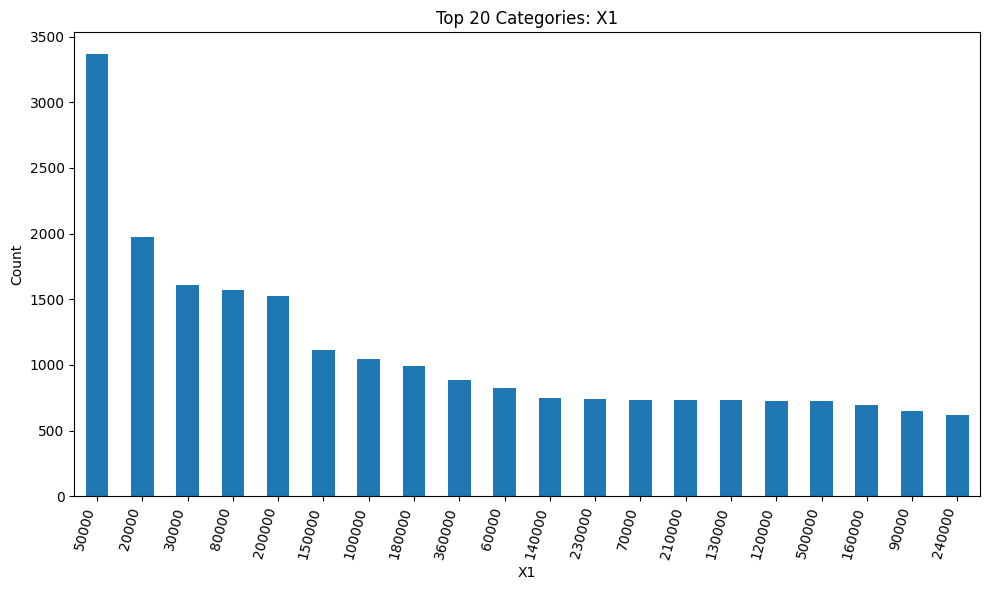

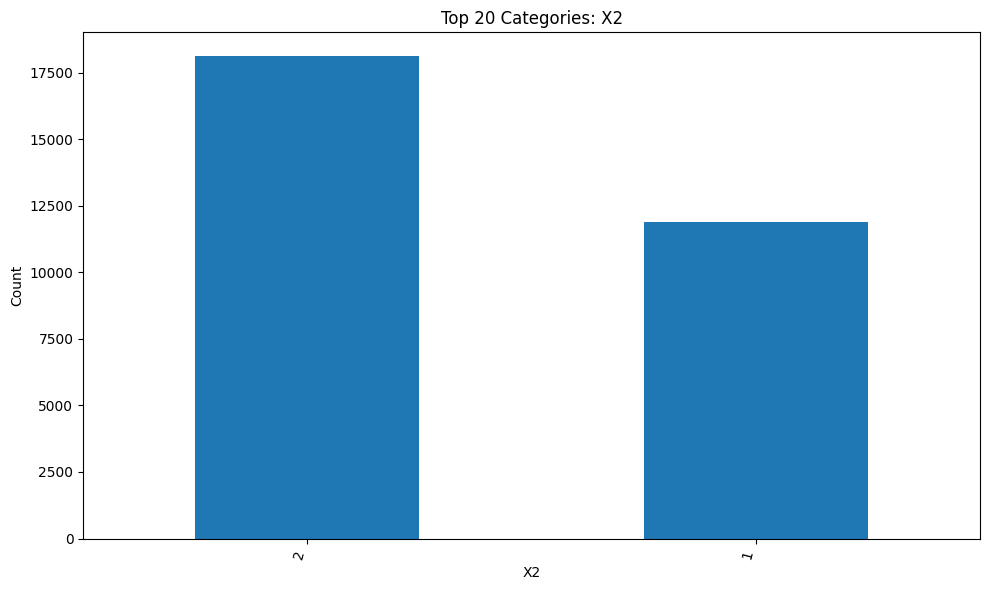

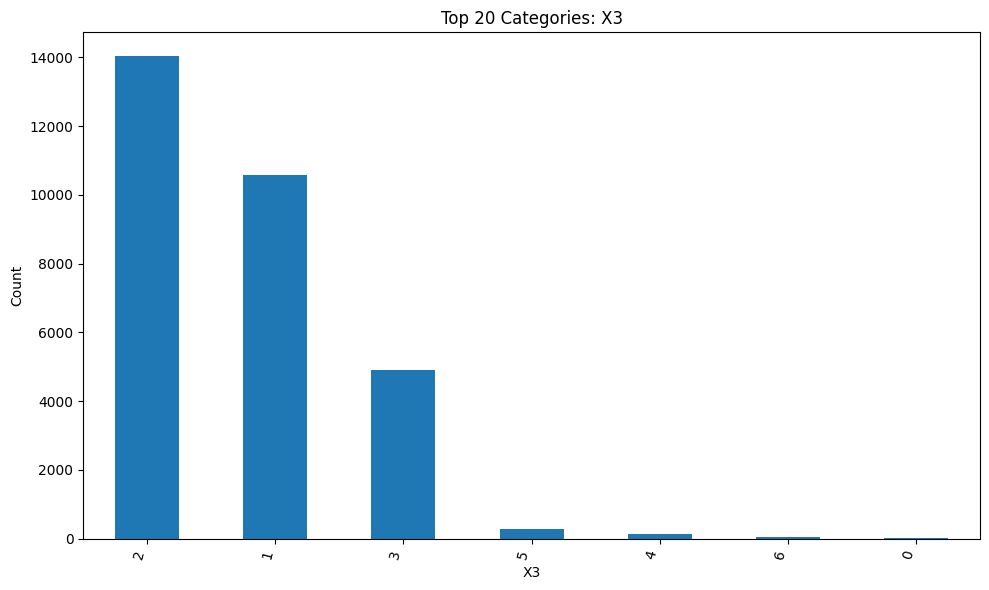

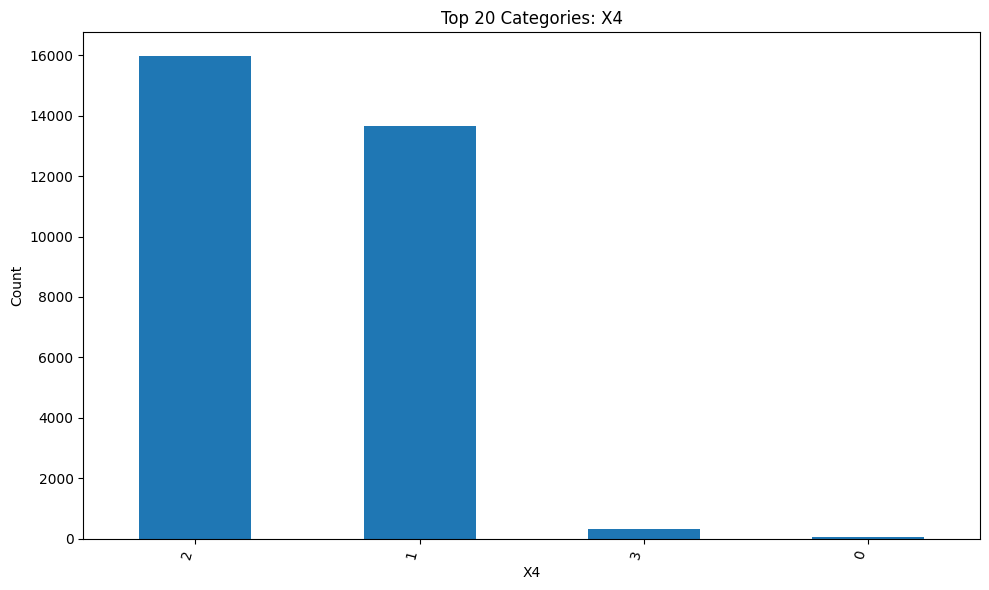

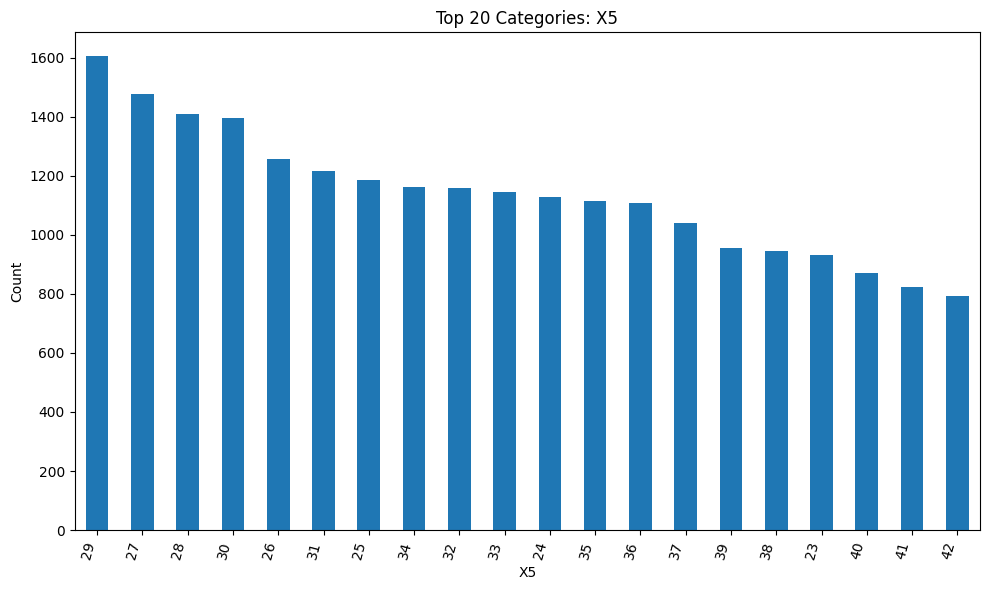

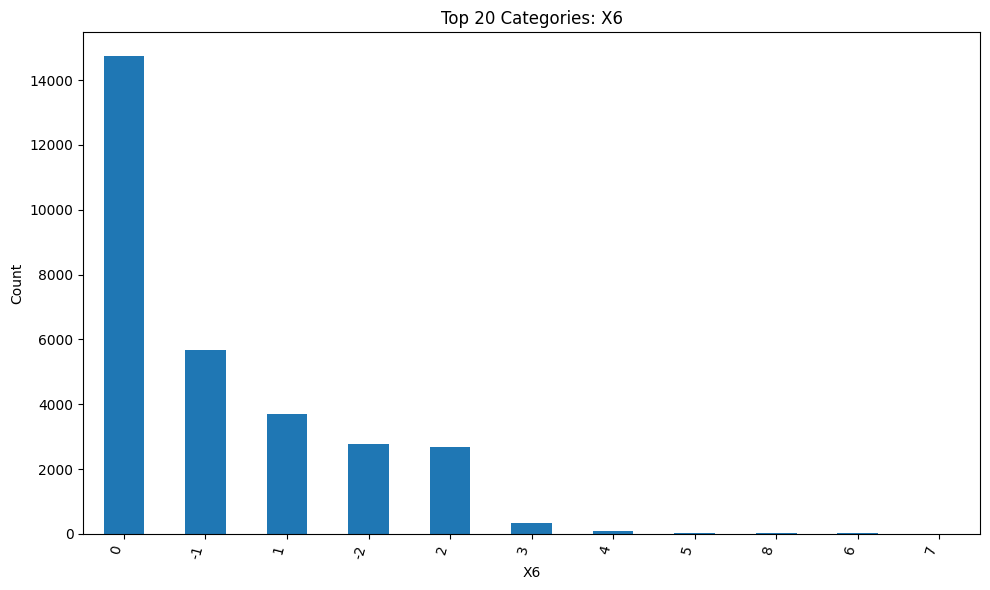

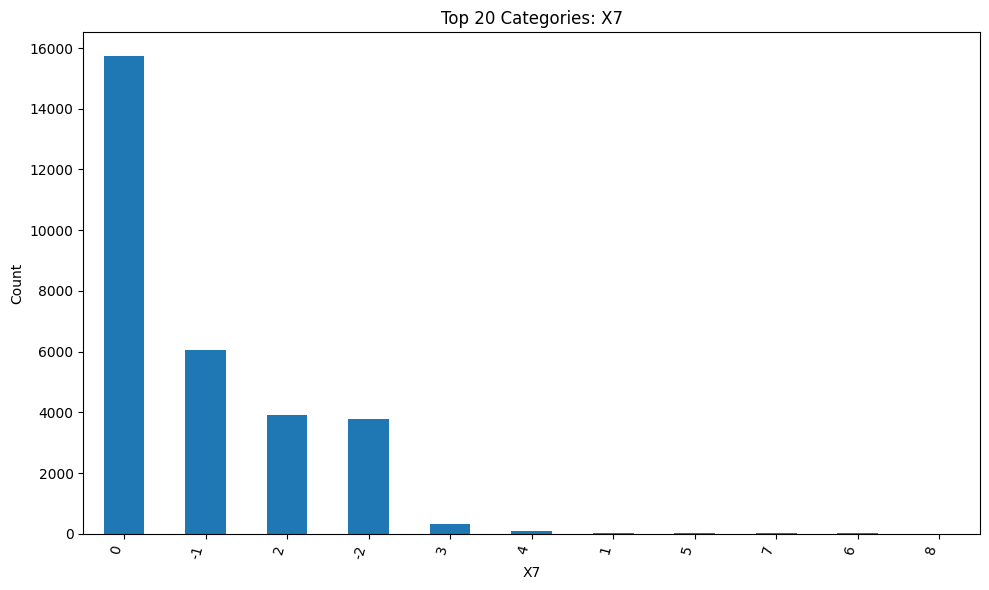

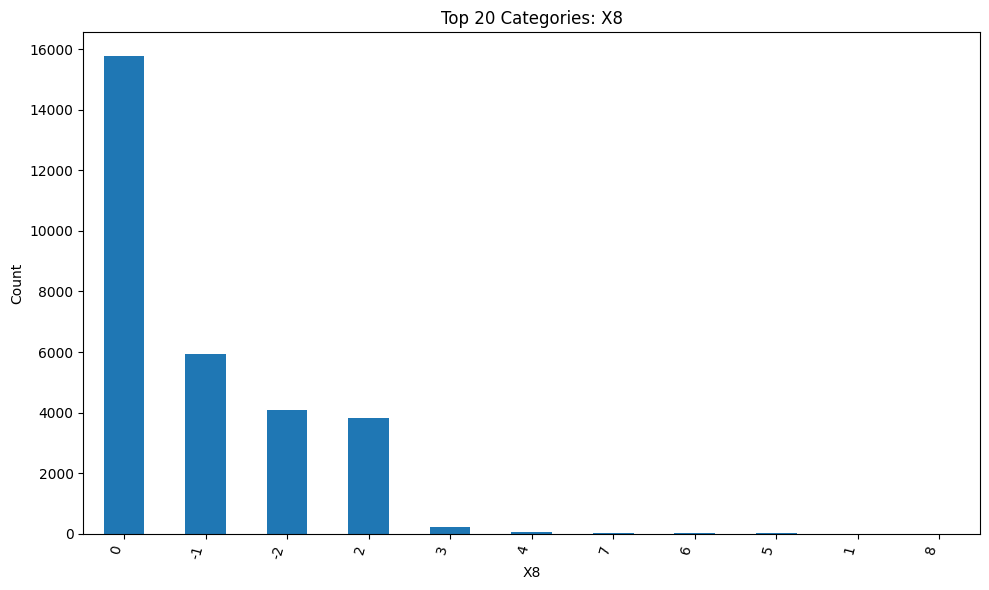

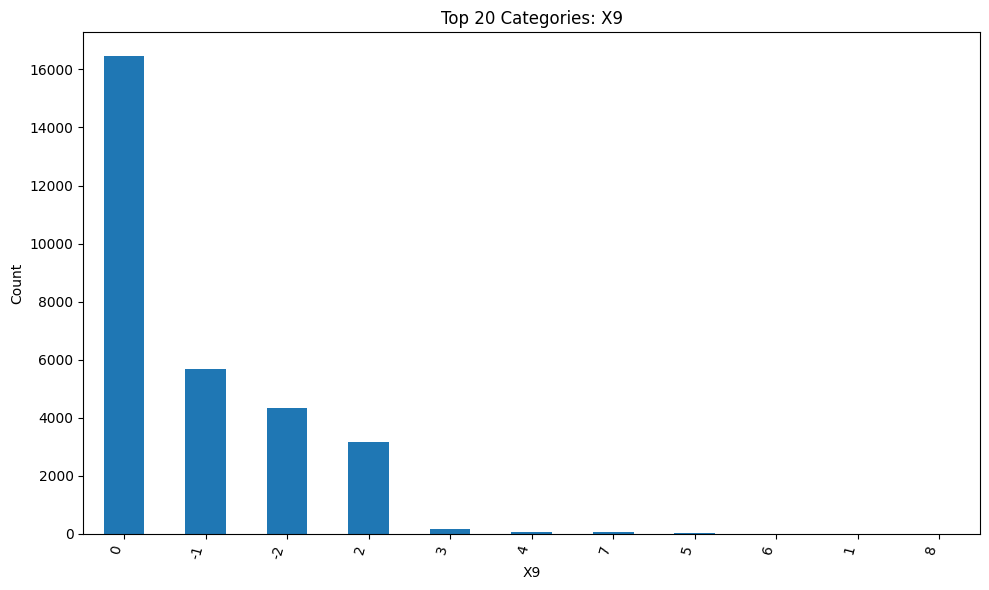

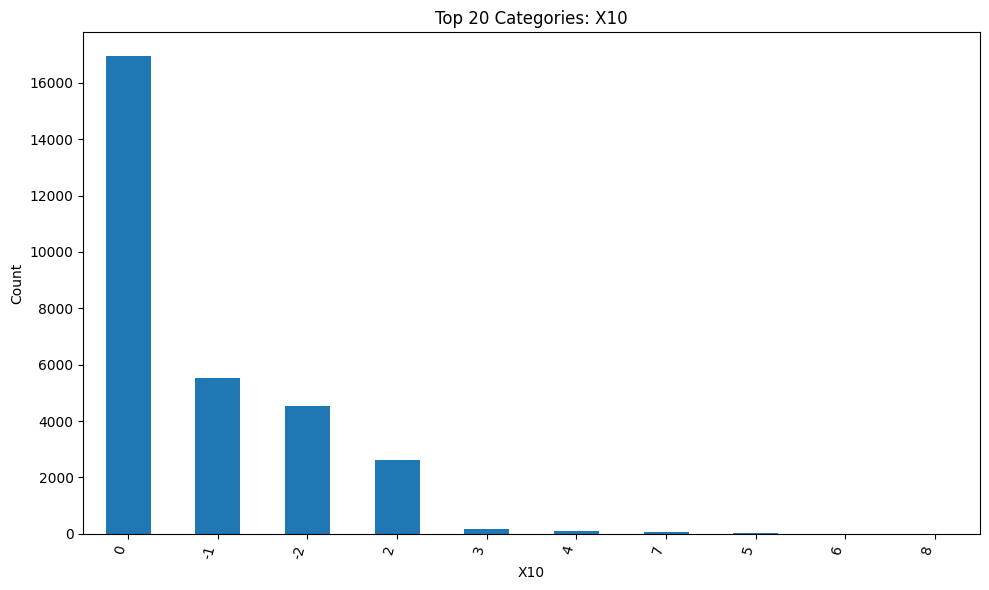

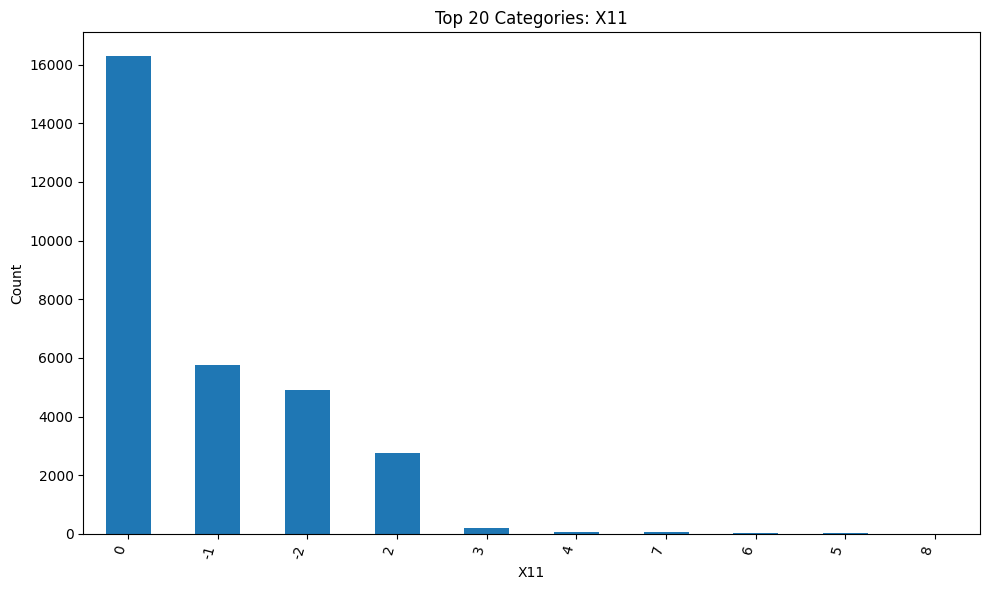

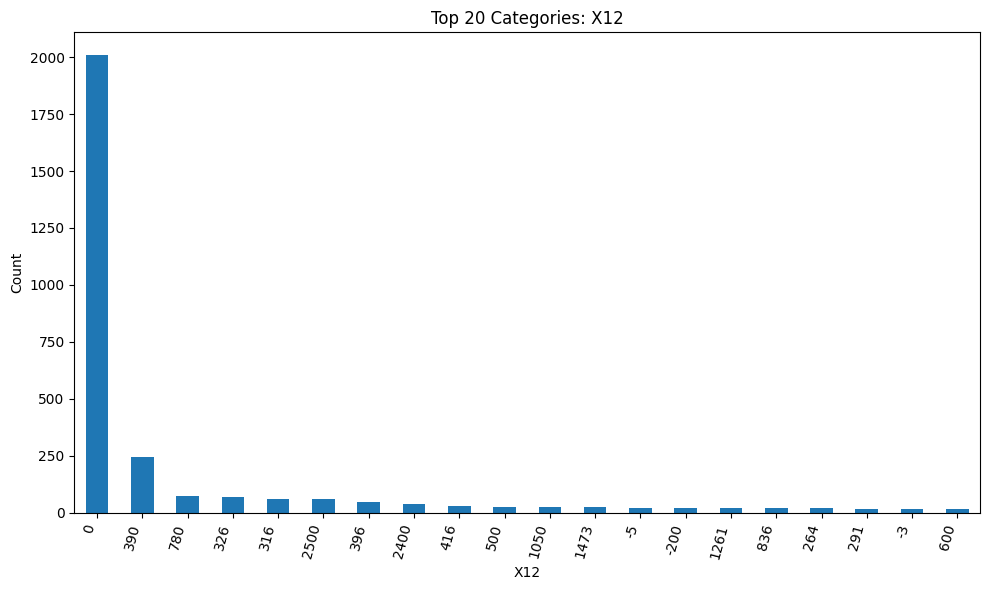

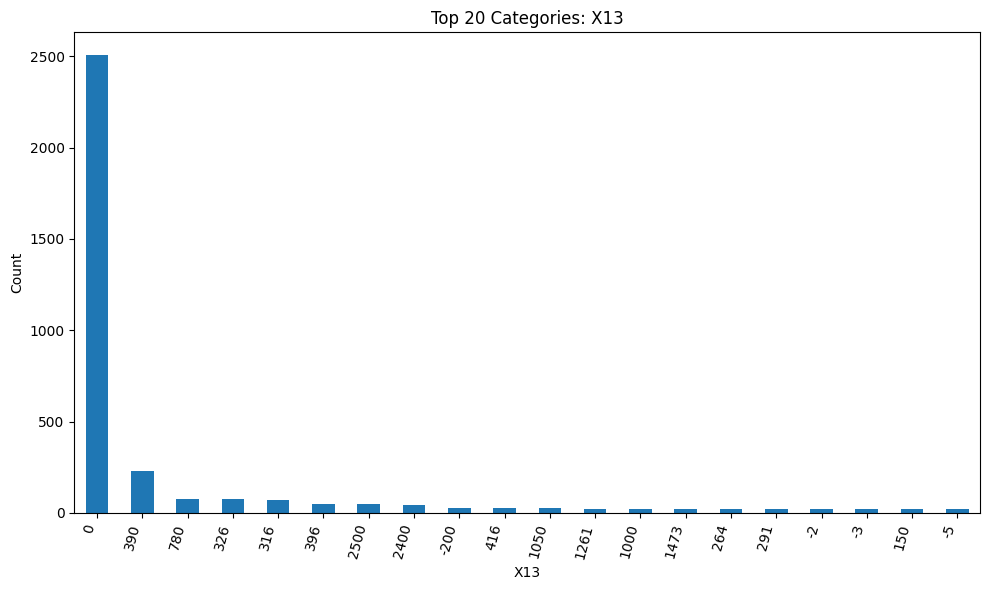

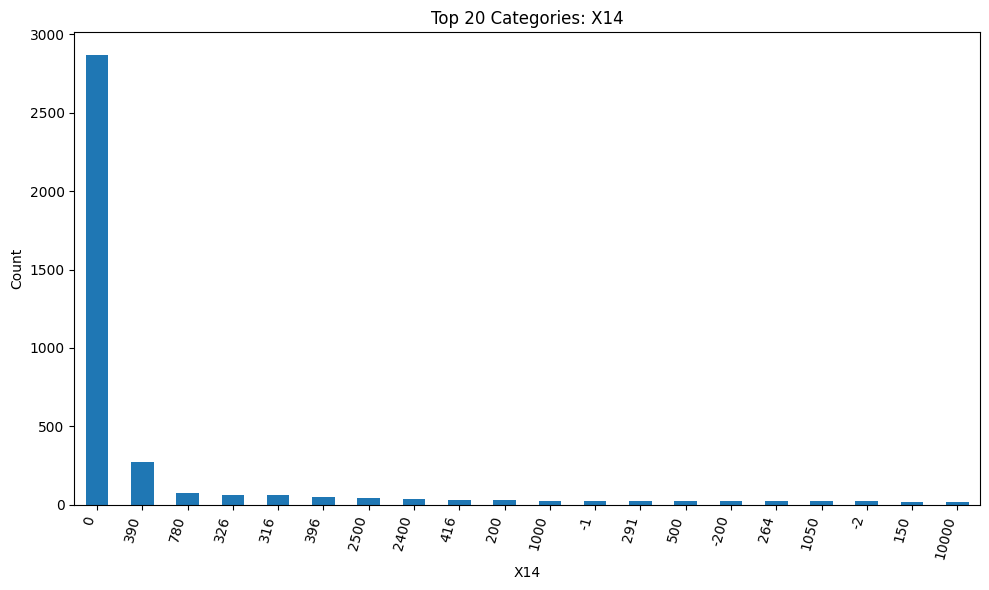

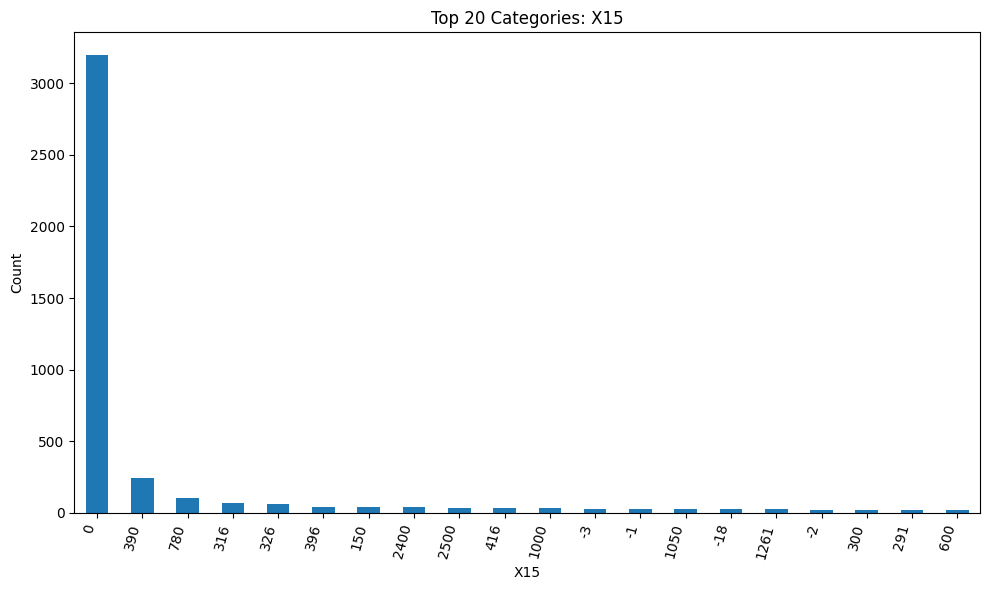

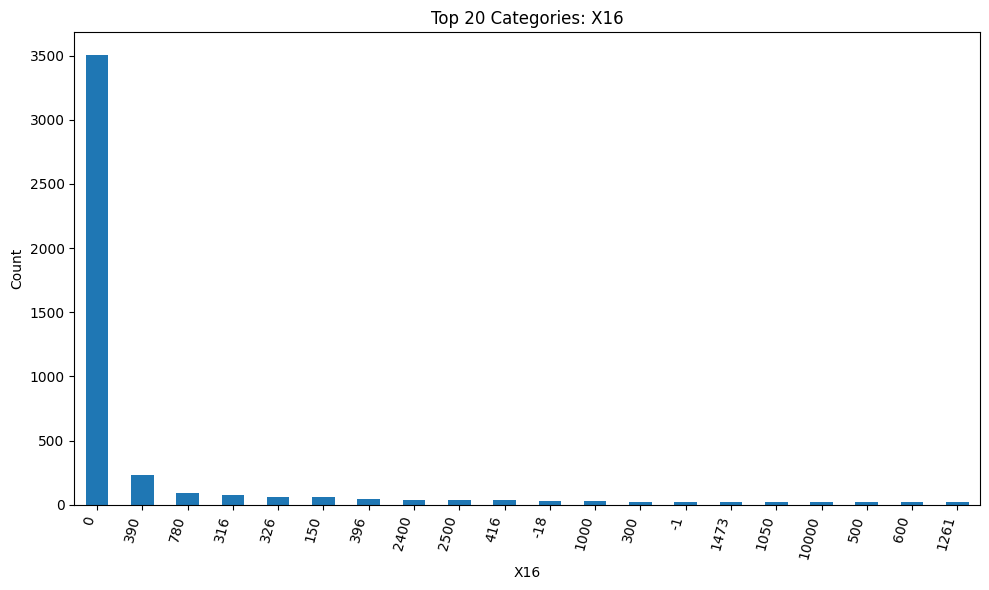

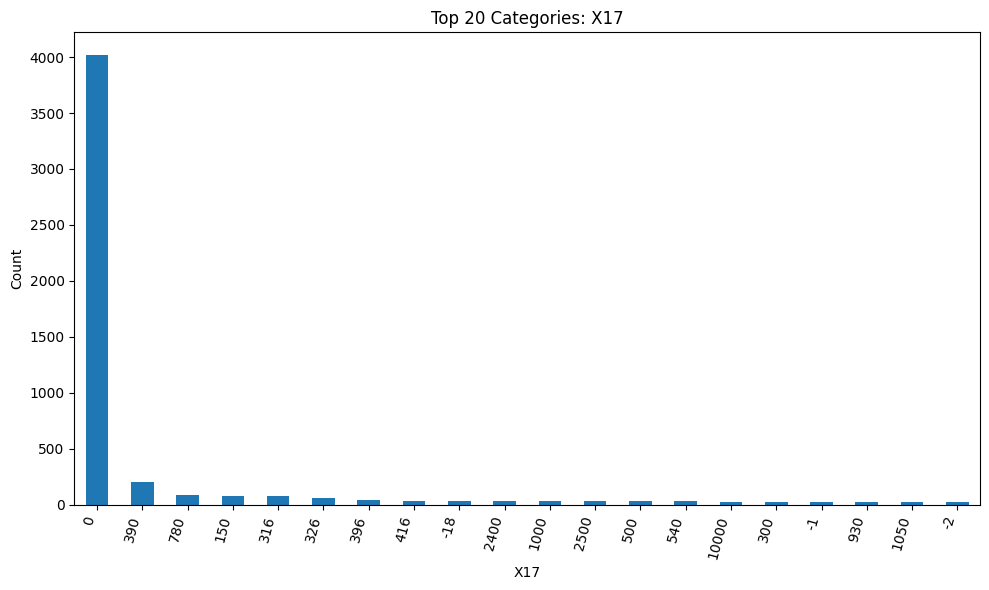

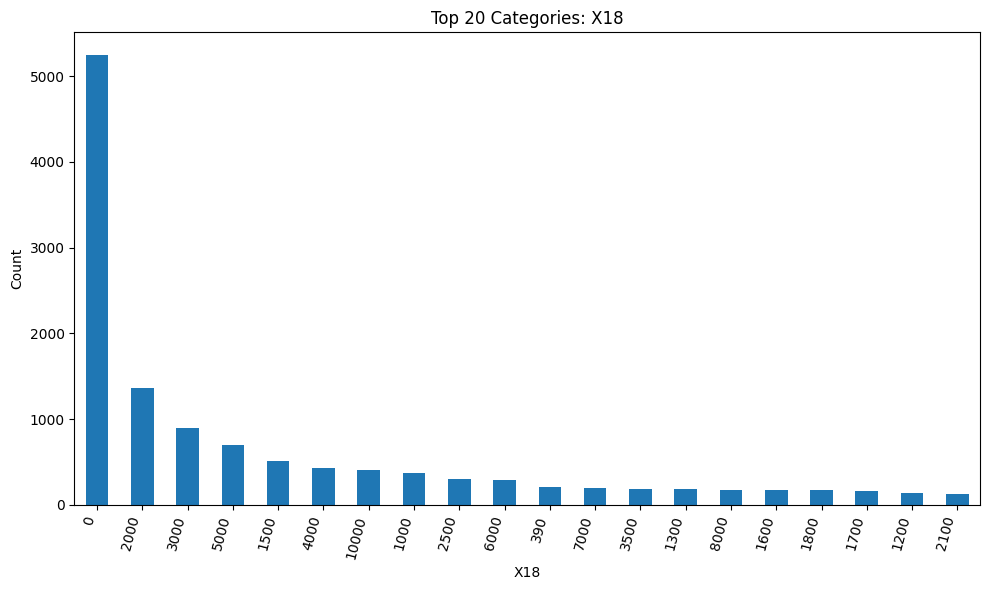

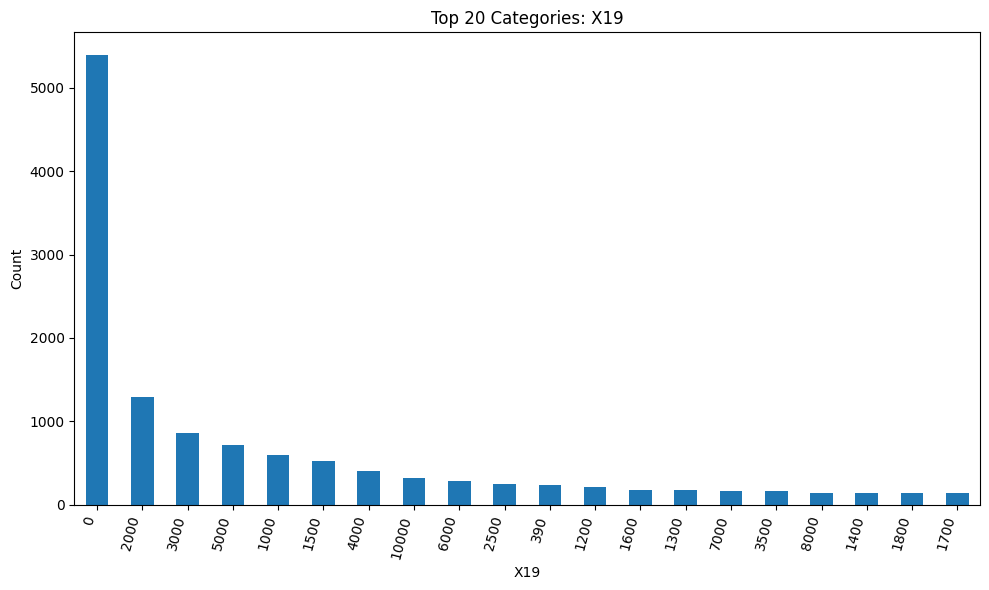

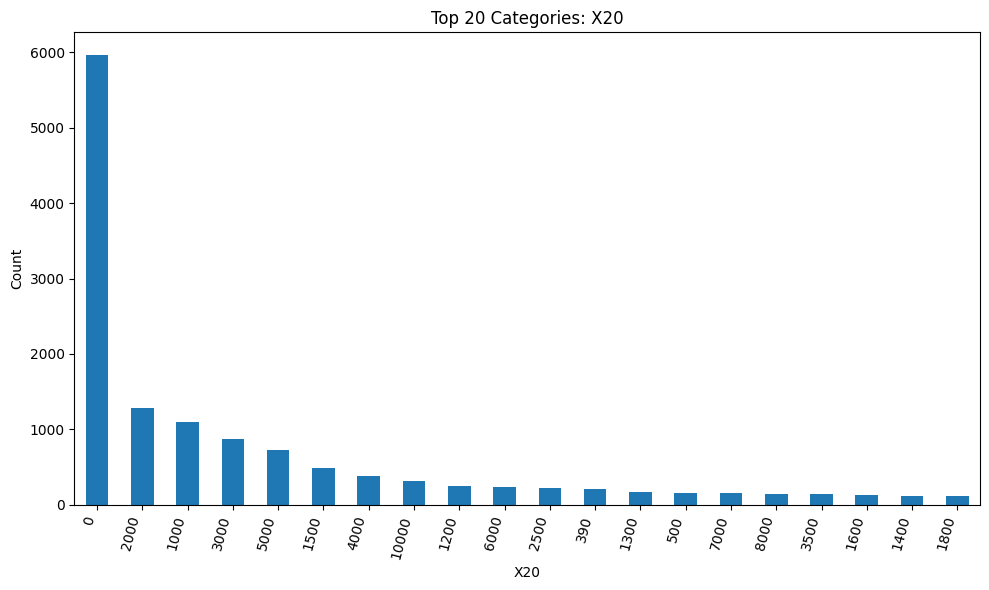

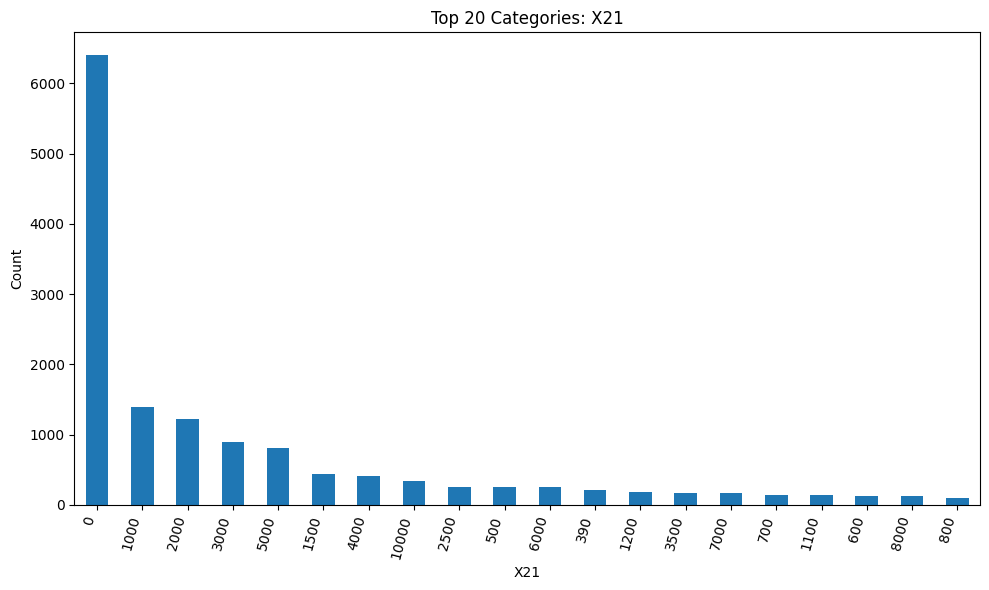

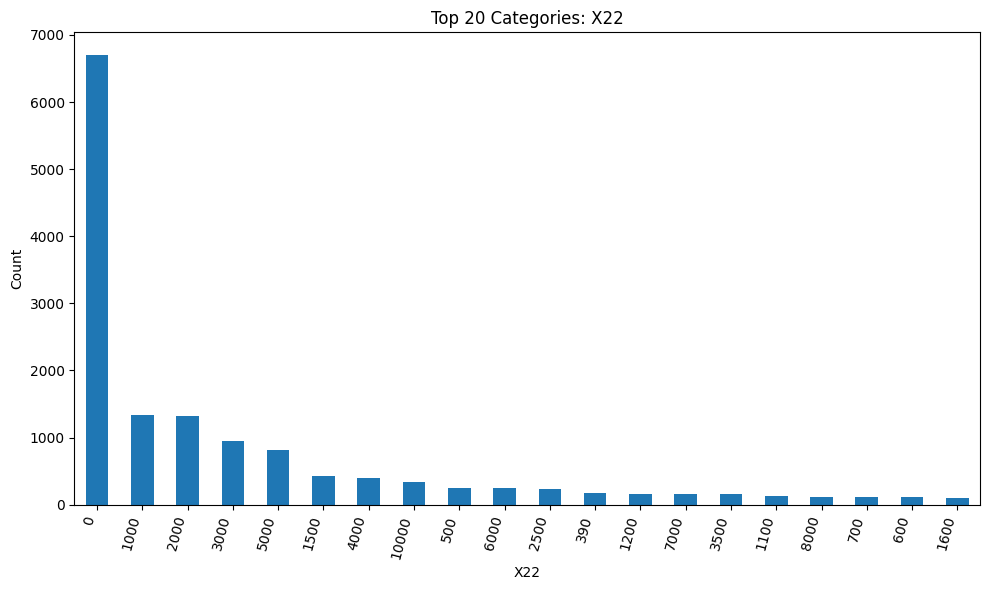

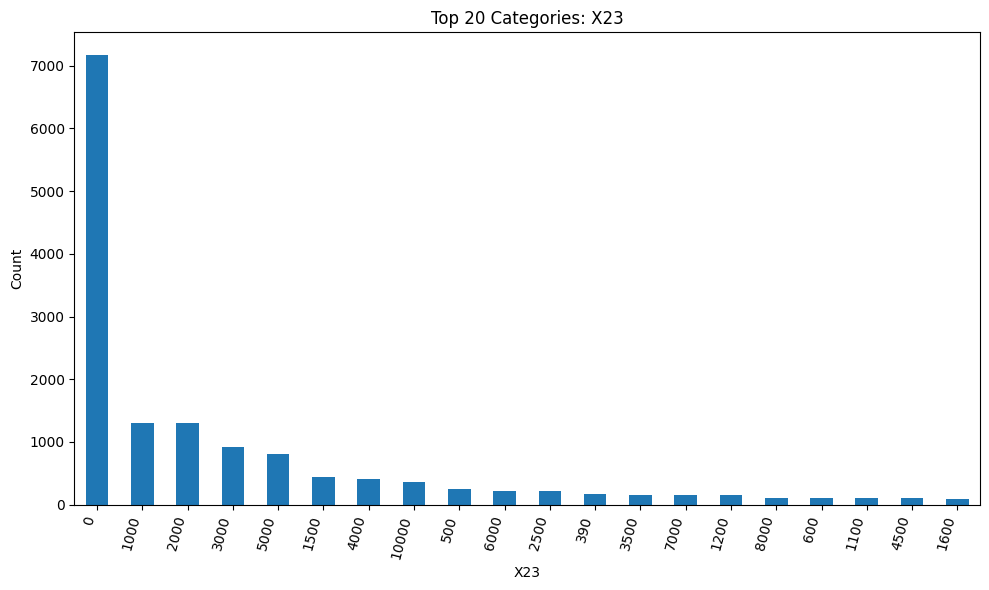

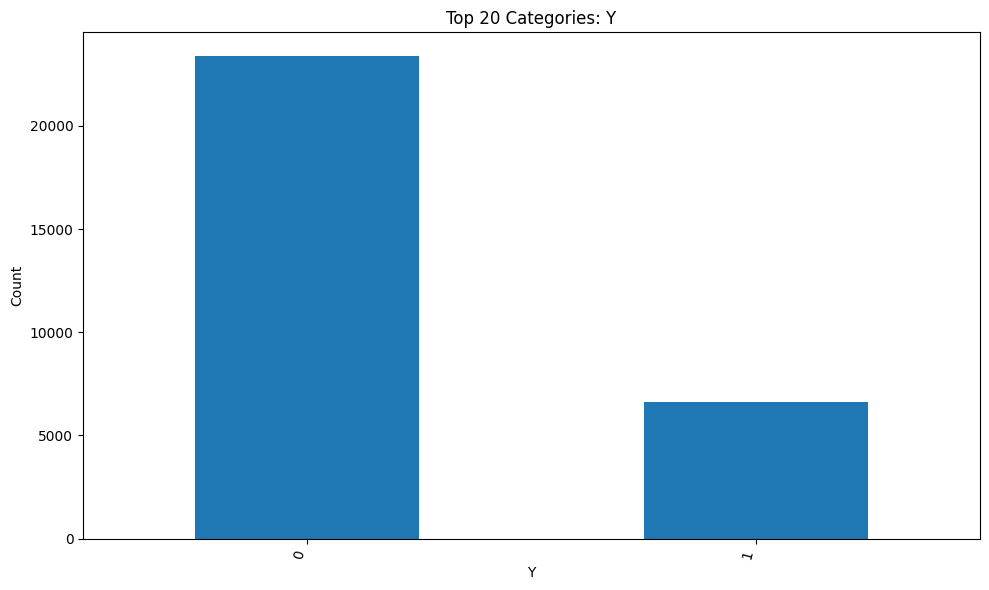

In [42]:
# === Univariate: Categorical ===
for c in cat_cols:
    vc = dfc[c].value_counts(dropna=False).head(20)
    plt.figure(figsize=(10,6))
    vc.plot(kind="bar")
    plt.title(f"Top 20 Categories: {c}")
    plt.xlabel(c); plt.ylabel("Count")
    plt.xticks(rotation=75, ha="right")
    plt.tight_layout()
    # Save the active figure, then display
    plt.gcf().savefig(Path(plots_dir) / f"bar_{c}.png", bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()

In [43]:
# === Bivariate vs Target: Numeric ===
import math

def mann_whitney_u(x, y):
    vals = np.concatenate([x, y])
    ranks = pd.Series(vals).rank(method='average').values
    r1 = ranks[:len(x)].sum()
    n1, n2 = len(x), len(y)
    u1 = r1 - n1*(n1+1)/2.0
    u2 = n1*n2 - u1
    u = min(u1, u2)
    mu = n1*n2/2.0
    sigma = np.sqrt(n1*n2*(n1+n2+1)/12.0)
    z = (u - mu)/sigma if sigma>0 else np.nan
    return u, z

if "__target_bin__" in dfc.columns and num_cols:
    tests = []
    for c in num_cols:
        g0 = dfc.loc[dfc["__target_bin__"]==0, c].dropna().values
        g1 = dfc.loc[dfc["__target_bin__"]==1, c].dropna().values
        # Boxplot
        plt.figure()
        plt.boxplot([g0, g1], labels=["class 0","class 1"])
        plt.title(f"{c} by target")
        plt.ylabel(c)
        plt.tight_layout()
        # Save current figure, then display
        plt.gcf().savefig(Path(plots_dir) / f"box_{c}_by_target.png", bbox_inches='tight', dpi=150)
        plt.show()
        plt.close()
        # Point-biserial correlation
        if np.std(dfc["__target_bin__"].values) > 0 and np.std(dfc[c].values) > 0:
            r = np.corrcoef(dfc["__target_bin__"].values, dfc[c].values)[0,1]
        else:
            r = np.nan
        u, z = mann_whitney_u(g0, g1)
        tests.append({"feature": c, "pointbiserial_r": r, "mannwhitney_u": u, "z_approx": z})
    tests_df = pd.DataFrame(tests).sort_values("pointbiserial_r", key=lambda s: s.abs(), ascending=False)
    tests_df.to_csv(Path(tables_dir) / "numeric_vs_target_tests.csv", index=False)
    display(tests_df.head(20))

In [44]:

# === Bivariate vs Target: Categorical ===
def chi_square_stat(tab):
    total = tab.values.sum()
    row_sums = tab.sum(axis=1).values.reshape(-1,1)
    col_sums = tab.sum(axis=0).values.reshape(1,-1)
    expected = row_sums @ col_sums / total if total>0 else np.zeros_like(tab.values)
    with np.errstate(divide='ignore', invalid='ignore'):
        chi2 = np.nansum((tab.values - expected)**2 / np.where(expected>0, expected, 1))
    dof = (tab.shape[0]-1)*(tab.shape[1]-1)
    return float(chi2), int(dof)

br_tables = []
chi_rows = []
if "__target_bin__" in dfc.columns:
    for c in [col for col in cat_cols if col != target_col]:
        tab = pd.crosstab(dfc[c], dfc["__target_bin__"])
        if 0 not in tab.columns: tab[0] = 0
        if 1 not in tab.columns: tab[1] = 0
        tab = tab[[0,1]]
        bad_rate = (tab[1] / tab.sum(axis=1)).rename("bad_rate")
        tmp = tab.assign(bad_rate=bad_rate).sort_values("bad_rate", ascending=False)
        tmp["column"] = c
        br_tables.append(tmp.reset_index().rename(columns={c:"category"}))
        chi2, dof = chi_square_stat(tab)
        chi_rows.append({"feature": c, "levels": tab.shape[0], "chi2": chi2, "dof": dof})

if br_tables:
    br_df = pd.concat(br_tables, ignore_index=True)
    br_df.to_csv(Path(tables_dir) / "categorical_bad_rates.csv", index=False)
    display(br_df.head(50))

if chi_rows:
    chi_df = pd.DataFrame(chi_rows).sort_values("chi2", ascending=False)
    chi_df.to_csv(Path(tables_dir) / "categorical_vs_target_chi2.csv", index=False)
    display(chi_df.head(20))


__target_bin__,category,0,1,bad_rate,column
0,327680,0,1,1.000000,X1
1,740000,1,1,0.500000,X1
2,40000,138,92,0.400000,X1
3,10000,296,197,0.399594,X1
4,20000,1278,698,0.353239,X1
5,30000,1042,568,0.352795,X1
6,720000,2,1,0.333333,X1
7,70000,521,210,0.287278,X1
8,550000,15,6,0.285714,X1
9,60000,592,233,0.282424,X1


,feature,levels,chi2,dof
11,X12,22723,22538.262825,22722
12,X13,22346,22220.160532,22345
13,X14,22026,21948.117501,22025
14,X15,21548,21490.054055,21547
15,X16,21010,20941.894677,21009
16,X17,20604,20539.776537,20603
17,X18,7943,7109.218638,7942
18,X19,7899,6700.578972,7898
19,X20,7518,6636.210262,7517
22,X23,6939,6188.916847,6938


In [45]:

# === WoE / IV (categorical) ===
def woe_iv(df_in, feature, target="__target_bin__"):
    grp = df_in.groupby(feature)[target]
    pos = grp.sum()  # class 1
    neg = grp.count() - pos  # class 0
    eps = 0.5
    pos = pos + eps; neg = neg + eps
    dist_pos = pos / pos.sum()
    dist_neg = neg / neg.sum()
    woe = np.log(dist_pos / dist_neg)
    iv = ((dist_pos - dist_neg) * woe).sum()
    out = pd.DataFrame({"pos": pos, "neg": neg, "dist_pos": dist_pos, "dist_neg": dist_neg, "woe": woe}).reset_index()
    out["feature"] = feature
    return iv, out

iv_rows = []; woe_tabs = []
if "__target_bin__" in dfc.columns:
    for c in [col for col in cat_cols if col != target_col]:
        try:
            iv, wtab = woe_iv(dfc, c)
            iv_rows.append({"feature": c, "IV": float(iv)})
            woe_tabs.append(wtab)
        except Exception:
            pass

if iv_rows:
    iv_df = pd.DataFrame(iv_rows).sort_values("IV", ascending=False)
    iv_df.to_csv(Path(tables_dir) / "iv_summary.csv", index=False)
    display(iv_df.head(20))

if woe_tabs:
    woe_df = pd.concat(woe_tabs, ignore_index=True)
    woe_df.to_csv(Path(tables_dir) / "woe_tables.csv", index=False)
    woe_df.head(20)


,feature,IV
5,X6,0.876685
13,X14,0.800684
12,X13,0.800633
11,X12,0.800051
14,X15,0.799439
15,X16,0.793832
16,X17,0.790000
6,X7,0.548645
17,X18,0.499578
19,X20,0.472906


In [46]:
# === Multivariate: Correlations and VIF ===
if len(num_cols) >= 2:
    corr = dfc[num_cols].corr()
    corr.to_csv(Path(tables_dir) / "correlation_numeric.csv")
    plt.figure(figsize=(8,6))
    im = plt.imshow(corr.values, aspect='auto')
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(ticks=np.arange(len(num_cols)), labels=num_cols, rotation=90)
    plt.yticks(ticks=np.arange(len(num_cols)), labels=num_cols)
    plt.title("Correlation Heatmap (Numeric)")
    plt.tight_layout()
    # Save the active figure then display
    plt.gcf().savefig(Path(plots_dir) / "corr_heatmap_numeric.png", bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()

def compute_vif_matrix(X: np.ndarray, col_names):
    vifs = []
    for j in range(X.shape[1]):
        y = X[:, j]
        Xo = np.delete(X, j, axis=1)
        Xd = np.column_stack([np.ones(Xo.shape[0]), Xo])
        beta, *_ = np.linalg.lstsq(Xd, y, rcond=None)
        yhat = Xd @ beta
        ss_res = np.sum((y - yhat)**2)
        ss_tot = np.sum((y - y.mean())**2)
        r2 = 1 - ss_res/ss_tot if ss_tot>0 else 0.0
        vifs.append({"feature": col_names[j], "R2": r2, "VIF": (np.inf if (1-r2)==0 else 1/(1-r2))})
    return pd.DataFrame(vifs)

if len(num_cols) >= 2:
    X = dfc[num_cols].fillna(dfc[num_cols].median()).values
    vif_df = compute_vif_matrix(X, num_cols).sort_values("VIF", ascending=False)
    vif_df.to_csv(Path(tables_dir) / "vif_numeric.csv", index=False)
    display(vif_df.head(20))

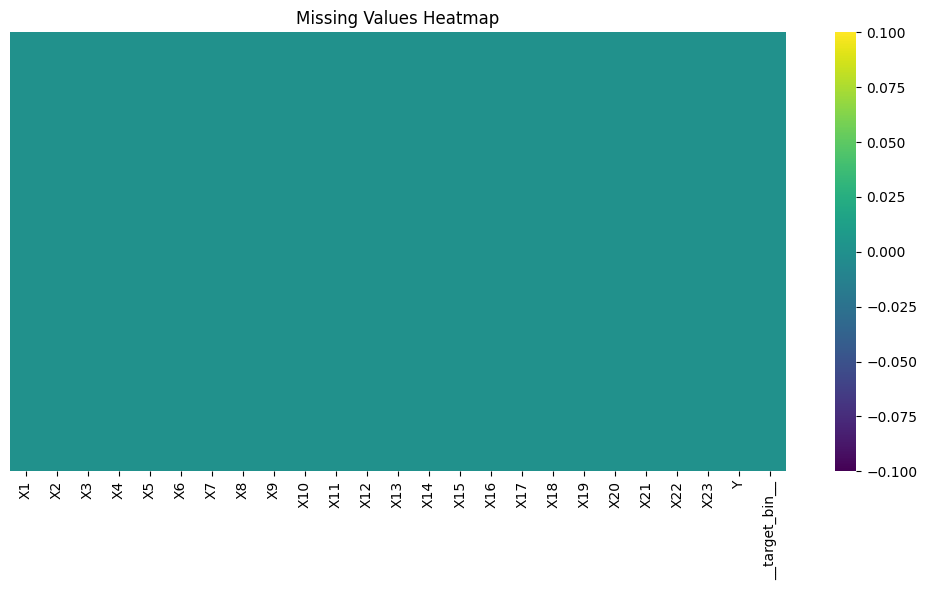

In [47]:
# === Additional visualizations: missingness heatmap, violin plots, pairplot ===
# Missingness heatmap (shows where values are missing)
plt.figure(figsize=(10,6))
sns.heatmap(dfc.isna().astype(int), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.tight_layout()
plt.gcf().savefig(Path(plots_dir) / 'missingness_heatmap.png', bbox_inches='tight', dpi=150)
plt.show()
plt.close()

# Violin plots for numeric columns by target (if binary target present)
if '__target_bin__' in dfc.columns and num_cols:
    for c in num_cols:
        plt.figure(figsize=(8,5))
        try:
            sns.violinplot(x=dfc['__target_bin__'].astype(str), y=dfc[c])
            plt.title(f'Violin: {c} by target')
            plt.xlabel('__target_bin__')
            plt.ylabel(c)
            plt.tight_layout()
            plt.gcf().savefig(Path(plots_dir) / f"violin_{c}_by_target.png", bbox_inches='tight', dpi=150)
            plt.show()
        except Exception as e:
            print(f"Could not plot violin for {c}: {e}")
        finally:
            plt.close()

# Pairplot (small set of numeric columns)
num_candidates = [c for c in num_cols if c in ['Age','Credit amount','Duration']]
if not num_candidates:
    num_candidates = num_cols[:4] if len(num_cols) >= 4 else num_cols
if num_candidates:
    try:
        ppdf = dfc[num_candidates + (["__target_bin__"] if '__target_bin__' in dfc.columns else [])].dropna()
        if '__target_bin__' in ppdf.columns:
            ppdf['RiskLabel'] = ppdf['__target_bin__'].map({0:'class0',1:'class1'})
            g = sns.pairplot(ppdf, vars=num_candidates, hue='RiskLabel', corner=True, diag_kind='hist')
        else:
            g = sns.pairplot(ppdf, vars=num_candidates, corner=True, diag_kind='hist')
        out = Path(plots_dir) / 'pairplot_numeric.png'
        g.fig.savefig(out, bbox_inches='tight', dpi=150)
        plt.show()
        plt.close()
    except Exception as e:
        print('Pairplot failed:', e)


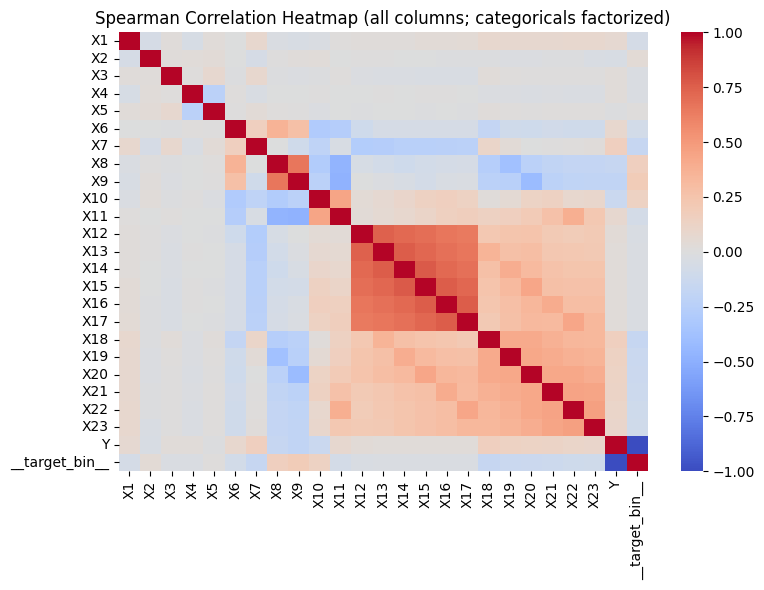

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20
X1,1.000000,-0.061031,0.021065,-0.053433,0.024021,-0.004478,0.085891,-0.028050,-0.039503,-0.029710,0.012304,0.018802,0.015641,0.023004,0.031353,0.036727,0.043432,0.081322,0.074262,0.074537
X2,-0.061031,1.000000,0.020898,0.029525,0.037988,-0.003589,-0.056860,0.001624,0.017644,0.025258,-0.002278,0.001624,0.004216,-0.001297,-0.006784,-0.012086,-0.008376,-0.015337,-0.022988,-0.022405
X3,0.021065,0.020898,1.000000,0.008120,0.074420,-0.011377,0.079892,-0.013441,-0.020222,-0.014576,0.007895,-0.023124,-0.024722,-0.030202,-0.032129,-0.034342,-0.032710,0.027311,0.014563,0.002100
X4,-0.053433,0.029525,0.008120,1.000000,-0.227776,0.010857,-0.035895,-0.003526,-0.000228,0.000420,-0.001824,-0.002085,0.006998,-0.005227,0.002500,0.000117,-0.003974,-0.021237,-0.022696,-0.027582
X5,0.024021,0.037988,0.074420,-0.227776,1.000000,0.003037,0.035573,0.009268,0.007087,-0.015770,-0.002308,-0.009974,-0.007599,-0.007399,-0.011980,-0.006591,-0.015351,0.019610,0.011437,0.004766
X6,-0.004478,-0.003589,-0.011377,0.010857,0.003037,1.000000,0.156357,0.365642,0.275079,-0.295325,-0.273383,-0.106503,-0.057697,-0.057325,-0.062266,-0.057467,-0.058124,-0.172623,-0.099942,-0.105785
X7,0.085891,-0.056860,0.079892,-0.035895,0.035573,0.156357,1.000000,-0.003133,-0.097458,-0.209857,-0.041478,-0.280767,-0.271266,-0.247823,-0.245933,-0.237835,-0.228381,0.106483,0.032879,-0.001413
X8,-0.028050,0.001624,-0.013441,-0.003526,0.009268,0.365642,-0.003133,1.000000,0.663718,-0.287887,-0.470707,-0.050683,-0.081606,-0.104809,-0.082540,-0.066980,-0.060467,-0.263559,-0.380550,-0.230708
X9,-0.039503,0.017644,-0.020222,-0.000228,0.007087,0.275079,-0.097458,0.663718,1.000000,-0.226842,-0.479456,-0.003990,-0.019730,-0.045858,-0.070716,-0.033274,-0.029366,-0.226731,-0.245959,-0.419560
X10,-0.029710,0.025258,-0.014576,0.000420,-0.015770,-0.295325,-0.209857,-0.287887,-0.226842,1.000000,0.441407,0.045038,0.069450,0.096896,0.145750,0.161166,0.133979,0.022687,0.053323,0.132571


Saved correlation CSV to: taiwan_eda\tables\correlation_all_columns.csv


In [48]:
# === Correlation heatmap across ALL columns (categoricals factorized) ===
# This creates a correlation matrix for all columns by factorizing non-numeric columns
# and using Spearman correlation (robust to monotonic relationships).

df_corr = dfc.copy()
for c in df_corr.columns:
    if not pd.api.types.is_numeric_dtype(df_corr[c]):
        # factorize to integers; preserves uniqueness but imposes arbitrary ordering
        df_corr[c] = pd.factorize(df_corr[c].astype(str))[0]

corr_all = df_corr.corr(method='spearman')
# Save CSV of correlation matrix
corr_all.to_csv(Path(tables_dir) / 'correlation_all_columns.csv')

# Plot heatmap (size scales with number of columns)
n = corr_all.shape[0]
w = max(8, min(40, int(n * 0.35)))
h = max(6, min(30, int(n * 0.25)))
plt.figure(figsize=(w, h))
ax = sns.heatmap(corr_all, cmap='coolwarm', center=0, xticklabels=True, yticklabels=True)
plt.title('Spearman Correlation Heatmap (all columns; categoricals factorized)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
# Save then show
plt.gcf().savefig(Path(plots_dir) / 'corr_heatmap_all_columns.png', bbox_inches='tight', dpi=150)
plt.show()
plt.close()

# Display top-left corner of matrix for quick inspection
display(corr_all.iloc[:20, :20])
print(f"Saved correlation CSV to: {Path(tables_dir)/'correlation_all_columns.csv'}")